#### Bernoulli Naive Bayes

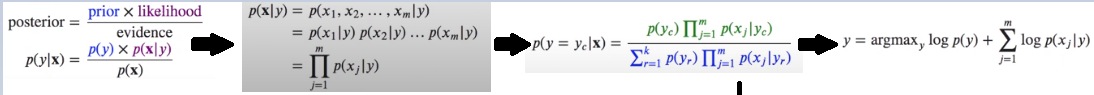

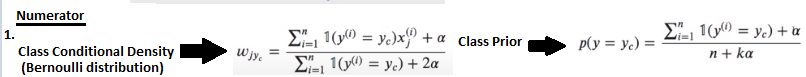

In [1]:
import numpy as np

In [2]:
def fit(X, y):
    alpha = 1 #Laplace correction
    n_samples, n_features = X.shape
    n_classes = len(np.unique(y))
    w = np.zeros((n_classes, n_features), dtype=np.float64)
    w_priors = np.zeros(n_classes, dtype=np.float64)
    
    for c in range(n_classes):
        X_c = X[y == c]
        w[c, :] = (np.sum(X_c, axis=0) + alpha) / (X_c.shape[0] + n_classes * alpha)
        w_priors[c] = (X_c.shape[0] + alpha) / (float(n_samples) + n_classes * alpha)
        
    print("Weight vector:", w)
    print("Prior", w_priors)
    return w, w_priors

In [3]:
# Testing it
X = np.array([[1,0],[0,1],[0,1],[1,0]])
y = np.array([1,0,0,1])
fit(X, y)

Weight vector: [[0.25 0.75]
 [0.75 0.25]]
Prior [0.5 0.5]


(array([[0.25, 0.75],
        [0.75, 0.25]]), array([0.5, 0.5]))

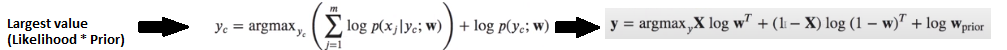

In [4]:
class BernoulliNB():
    def __init__(self, alpha=1.0):
        self.alpha = alpha
    def fit(self, X, y):
        n_samples, n_features = X.shape
        n_classes = len(np.unique(y))
        self.w = np.zeros((n_classes, n_features), dtype=np.float64)
        self.w_priors = np.zeros(n_classes, dtype=np.float64)

        for c in range(n_classes):
            X_c = X[y == c]
            self.w[c, :] = (np.sum(X_c, axis=0) + self.alpha) / (X_c.shape[0] + n_classes * self.alpha)
            self.w_priors[c] = (X_c.shape[0] + self.alpha) / (float(n_samples) + n_classes * self.alpha)

        print("Class Conditional Density:", self.w)
        print("Prior", self.w_priors)

    def log_likelihood_prior_prod(self, X):
        return X @ (np.log(self.w).T) + (1 - X) @ np.log((1 - self.w).T) + np.log(self.w_priors)
    
    def predict_proba(self, X):
        q = self.log_likelihood_prior_prod(X)
        return np.exp(q) / np.expand_dims(np.sum(np.exp(q), axis=1), axis=1)
    
    def predict(self, X):
        q = self.log_likelihood_prior_prod(X)
        return np.argmax(q, axis=1)

#### Binary classification with Bernoulli Naive Bayes

In [5]:
X = np.array([[1,0],[0,1],[0,1],[1,0]])
y = np.array([1,0,0,1])

In [6]:
bernoulli_nb = BernoulliNB()
bernoulli_nb.fit(X, y)

Class Conditional Density: [[0.25 0.75]
 [0.75 0.25]]
Prior [0.5 0.5]


In [7]:
bernoulli_nb.predict(X) #note the prediction is matching with the input labels.

array([1, 0, 0, 1], dtype=int64)

In [8]:
bernoulli_nb.log_likelihood_prior_prod(X)

array([[-3.4657359 , -1.26851133],
       [-1.26851133, -3.4657359 ],
       [-1.26851133, -3.4657359 ],
       [-3.4657359 , -1.26851133]])

In [9]:
bernoulli_nb.predict_proba(X)

array([[0.1, 0.9],
       [0.9, 0.1],
       [0.9, 0.1],
       [0.1, 0.9]])

#### Multi-class classification with Bernoulli Naive Bayes

In [10]:
X = np.array([[1,0],[0,1],[0,1],[1,0],[1,1],[1,1]])
y = np.array([1,0,0,1,2,2])

In [11]:
bernoulli_nb = BernoulliNB()
bernoulli_nb.fit(X, y)

Class Conditional Density: [[0.2 0.6]
 [0.6 0.2]
 [0.6 0.6]]
Prior [0.33333333 0.33333333 0.33333333]


In [12]:
bernoulli_nb.predict(X) #note the prediction is matching with the input labels.

array([1, 0, 0, 1, 2, 2], dtype=int64)

In [13]:
bernoulli_nb.log_likelihood_prior_prod(X)

array([[-3.62434093, -1.83258146, -2.52572864],
       [-1.83258146, -3.62434093, -2.52572864],
       [-1.83258146, -3.62434093, -2.52572864],
       [-3.62434093, -1.83258146, -2.52572864],
       [-3.21887582, -3.21887582, -2.12026354],
       [-3.21887582, -3.21887582, -2.12026354]])

In [14]:
bernoulli_nb.predict_proba(X)

array([[0.1, 0.6, 0.3],
       [0.6, 0.1, 0.3],
       [0.6, 0.1, 0.3],
       [0.1, 0.6, 0.3],
       [0.2, 0.2, 0.6],
       [0.2, 0.2, 0.6]])

#### Gaussian Naive Bayes

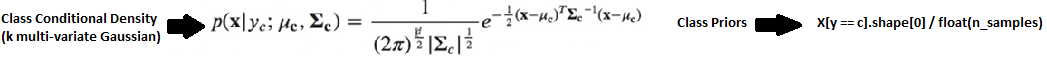

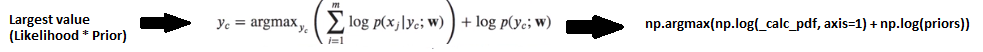

In [15]:
class GaussianNB():
    def __init__(self, alpha=1.0):
        self.alpha = alpha
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self._classes = np.unique(y)
        n_classes = len(self._classes)
        self._mean = np.zeros((n_classes, n_features), dtype=np.float64)
        self._var = np.zeros((n_classes, n_features), dtype=np.float64)
        self._priors = np.zeros(n_classes, dtype=np.float64)

        for idx, c in enumerate(self._classes):
            X_c = X[y == c]
            self._mean[idx, :] = X_c.mean(axis=0)
            self._var[c] = X_c.var(axis=0)
            self._priors[idx] = X_c.shape[0] / float(n_samples)

        print("Mean:", self._mean)
        print("Variance:", self._var)
        print("Prior", self._priors)
    
    def _calc_pdf(self, class_idx, X):
        mean = self._mean[class_idx]
        var = np.diag(self._var[class_idx])
        z = np.power(2 * np.pi, X.shape[0] / 2) * np.power(np.linalg.det(var), 1/2)
        return (1/z) * np.exp(-0.5 * (X - mean).T @ (np.linalg.inv(var)) @ (X - mean))
    
    def _calc_prod_likelihood_prior(self, X):
        self.q = np.zeros((X.shape[0], len(self._classes)), dtype=np.float64)
        for x_idx, x in enumerate(X):
            for idx, c in enumerate(self._classes):
                self.q[x_idx, c] = (np.log(self._calc_pdf(idx, x)) 
                                                         + np.log(self._priors[idx]))
    
    def predict_proba(self, X):
        self._calc_prod_likelihood_prior(X)
        return np.exp(self.q) / np.expand_dims(np.sum(np.exp(self.q), axis=1), axis=1)
    
    def predict(self, X):
        self._calc_prod_likelihood_prior(X)
        return np.argmax(self.q, axis=1)

In [16]:
# Testing it
from sklearn.datasets import make_classification, make_blobs
from sklearn.model_selection import train_test_split

X, y = make_blobs(n_samples=100, n_features=2, centers=[[5,5],[10,10]], cluster_std=1.5, random_state=2)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

D:\Anaconda3\lib\site-packages\sklearn\feature_extraction\image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):


In [17]:
gaussian_nb = GaussianNB()
gaussian_nb.fit(X_train, y_train)

Mean: [[ 4.55853975  5.01739665]
 [10.30431548 10.08580617]]
Variance: [[2.13298417 2.30222002]
 [3.22242307 2.20662074]]
Prior [0.5125 0.4875]


In [18]:
gaussian_nb.predict_proba(X_test)

array([[9.99999746e-01, 2.54140753e-07],
       [7.63749214e-14, 1.00000000e+00],
       [4.23038642e-03, 9.95769614e-01],
       [9.99986614e-01, 1.33855473e-05],
       [7.05769182e-06, 9.99992942e-01],
       [9.99820566e-01, 1.79433743e-04],
       [9.72541524e-01, 2.74584756e-02],
       [9.99982043e-01, 1.79572091e-05],
       [2.85910189e-05, 9.99971409e-01],
       [1.01888837e-07, 9.99999898e-01],
       [7.39129058e-01, 2.60870942e-01],
       [9.99793438e-01, 2.06561658e-04],
       [9.99999915e-01, 8.46737165e-08],
       [2.03213294e-05, 9.99979679e-01],
       [8.76198350e-09, 9.99999991e-01],
       [6.51163513e-05, 9.99934884e-01],
       [9.27638525e-05, 9.99907236e-01],
       [7.58034673e-09, 9.99999992e-01],
       [1.81773339e-03, 9.98182267e-01],
       [9.99985544e-01, 1.44557945e-05]])

In [19]:
gaussian_nb.predict(X_test)

array([0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0],
      dtype=int64)

In [20]:
from sklearn.metrics import classification_report
print(classification_report(y_test, gaussian_nb.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00        11

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20

